In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [3]:
MIN_CMD = 20000
MAX_CMD = 65535
HOVER_CMD =38726.7

In [5]:
def cmd_to_freq(cmd):
    return 3.43703919 * np.sqrt(cmd) - 38.06894012

In [4]:
def semitones_to_freq(f1,n_semitones):
    return np.power(2,(n_semitones*100/1200))*f1

In [5]:
def find_note_range(min_freq, max_freq, c_freq):
    intervals = []
    freqs = []
    intervals.append(0)
    freqs.append(c_freq)
    i = 1
    while semitones_to_freq(c_freq,i) < max_freq : 
        intervals.append(i)
        freqs.append(semitones_to_freq(c_freq,i))
        i = i+1
    j = -1
    while semitones_to_freq(c_freq,j) > min_freq : 
        intervals.append(j)
        freqs.append(semitones_to_freq(c_freq,j))
        j = j-1
    return pd.DataFrame({'interval_no': sorted(intervals),'interval_freq': sorted(freqs)})
        

In [6]:
MIN_FREQ = cmd_to_freq(MIN_CMD)
MIN_FREQ

448.0018035705838

In [7]:
MAX_FREQ = cmd_to_freq(MAX_CMD)
MAX_FREQ

841.806379527224

### CASE 1 :  C is HOVER_FREQ

In [8]:
HOVER_FREQ = cmd_to_freq(HOVER_CMD)
HOVER_FREQ

638.3094593704543

In [9]:
intervals1 = find_note_range(MIN_FREQ, MAX_FREQ, HOVER_FREQ)

In [10]:
intervals1

,interval_no,interval_freq
0,-6,451.352947
1,-5,478.191790
2,-4,506.626554
3,-3,536.752136
4,-2,568.669079
5,-1,602.483902
6,0,638.309459
7,1,676.265315
8,2,716.478143
9,3,759.082151


### CASE2 : ALL CASES

In [11]:
c_freqs = np.linspace(MIN_FREQ, MAX_FREQ, 10000)

In [12]:
c_freqs

array([448.00180357, 448.04118797, 448.08057236, ..., 841.72761074,
       841.76699513, 841.80637953])

In [13]:
all_intervals = pd.DataFrame({'c_freqs': c_freqs})

In [14]:
all_intervals['n_intervals'] = all_intervals.c_freqs.apply(lambda x : len( find_note_range(MIN_FREQ, MAX_FREQ, x)))
all_intervals['max_up'] = all_intervals.c_freqs.apply(lambda x : find_note_range(MIN_FREQ, MAX_FREQ, x).interval_no.max())
all_intervals['max_down'] = all_intervals.c_freqs.apply(lambda x : find_note_range(MIN_FREQ, MAX_FREQ, x).interval_no.min())

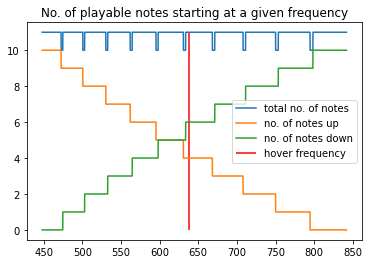

In [15]:
plt.plot(all_intervals.c_freqs, all_intervals.n_intervals, label = 'total no. of notes')
plt.plot(all_intervals.c_freqs, all_intervals.max_up, label = 'no. of notes up')
plt.plot(all_intervals.c_freqs, -all_intervals.max_down, label = 'no. of notes down')
plt.vlines(HOVER_FREQ, 0, 11, colors = 'red', label= 'hover frequency')
plt.legend()
plt.title('No. of playable notes starting at a given frequency')
plt.show()

### 2 NOTES CHORD STUDY

In [16]:
def cmd2_to_hover(cmd1):
    cmd2 = HOVER_CMD + (HOVER_CMD-cmd1)
    return HOVER_CMD + (HOVER_CMD-cmd1)

In [17]:
EPSILON = 2
def perceivable_freq_range(freq):
    return semitones_to_freq(freq,-EPSILON/100),semitones_to_freq(freq,+EPSILON/100)

In [18]:
def is_interval(freq1,freq2):
    allowed_freqs = find_note_range(MIN_FREQ,MAX_FREQ,freq1)
    #print(allowed_freqs)
    interval_no = 0
    for allowed_freq in allowed_freqs['interval_freq']:
        min_freq2, max_freq2 = perceivable_freq_range(freq2)
        #print("testing " + str(allowed_freq) +  ' Hz')
        if allowed_freq <= max_freq2 and allowed_freq >= min_freq2:
            #print(allowed_freqs[allowed_freqs['interval_freq'] == freq2])
            #print('allowed_freq, freq1, freq2 : ')
            #print(allowed_freq, freq1, freq2)
            interval_no = allowed_freqs[allowed_freqs['interval_freq'] == allowed_freq]['interval_no'].item()
            #print('IS INTERVAL ! interval no : ', interval_no)
    return [freq1, freq2, interval_no]
        

In [19]:
cmds = np.linspace(MIN_CMD, MAX_CMD, 10000)

In [20]:
PWM2RPM_SCALE = 0.2685
PWM2RPM_CONST = 4070.3
def cmd_to_rpm(cmd):
    return PWM2RPM_SCALE * cmd + PWM2RPM_CONST
def rpm_to_cmd(rpm):
    return (rpm - PWM2RPM_CONST)/PWM2RPM_SCALE

In [21]:
HOVER_RPM = cmd_to_rpm(HOVER_CMD)

In [22]:
def cmd2_to_hover_quadratic(cmd1):
    rpm1 = cmd_to_rpm(cmd1)
    if 2*(np.power(HOVER_RPM,2) - 0.5*np.power(rpm1,2)) < 0:
        print('command : ', cmd1, '  leads to negative rpm')
        return -1
    else:
        rpm2 = np.sqrt(2*(np.power(HOVER_RPM,2) - 0.5*np.power(rpm1,2)))
        return rpm_to_cmd(rpm2)

In [23]:
def freq_to_cmd(freq):
    return np.power((1/3.43703919)*( freq + 38.06894012),2)

In [24]:
cmds1 = []
cmds2 = []
cmds1_good = []
cmds2_good = []
interval_list_ids = []
interval_list = []
prev_int_no = 0
for cmd1_id, cmd1 in enumerate(cmds):
    cmd2 = cmd2_to_hover_quadratic(cmd1)
    if cmd2 < 0:
        break
    cmds1.append(cmd1)
    cmds2.append(cmd2)
    if cmd2 <= MAX_CMD and cmd2 >= MIN_CMD and cmd2 >=0 :
            temp = is_interval(cmd_to_freq(cmd2),cmd_to_freq(cmd1))
            int_no = temp[2]
            if int_no != 0:
                if int_no!=prev_int_no:
                    interval_list.append(temp)
                    cmds1_good.append(freq_to_cmd(temp[0]))
                    cmds2_good.append(freq_to_cmd(temp[1]))
                    interval_list_ids.append(cmd1_id)
                    prev_int_no = int_no
                

In [25]:
interval_list

[[742.5701892461574, 467.26529474637283, -8],
 [734.1543238828257, 489.4537553114486, -7],
 [724.5795997228537, 511.77416080760725, -6],
 [713.7135175176561, 534.117060524736, -5],
 [701.5066957412661, 556.2084055018281, -4],
 [687.9214646029178, 577.8132616279339, -3],
 [672.8731052852181, 598.8122106629414, -2],
 [656.4536584061674, 618.8949342680801, -1],
 [619.6715455608761, 655.7736341567092, 1],
 [599.577714658502, 672.2859063826587, 2],
 [578.6102262207957, 687.3855264873151, 3],
 [556.9821213002127, 701.049895053906, 4],
 [534.9410656200449, 713.2857179432585, 5],
 [512.6105789542107, 724.1970824303945, 6],
 [490.3178867176041, 733.8053089468008, 7],
 [468.127431637266, 742.2619607088968, 8]]

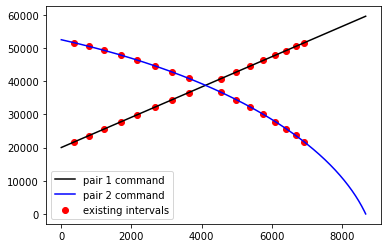

In [26]:
plt.plot(cmds1, label = 'pair 1 command', color = 'black')
plt.plot(cmds2, label = 'pair 2 command', color = 'blue')
plt.scatter(interval_list_ids+interval_list_ids, cmds1_good+cmds2_good, label = 'existing intervals', marker='o', color = 'red')
plt.legend()
#x axis is index

In [27]:
cmds1_good

[51585.97752737439,
 50479.70332931376,
 49235.67746163059,
 47842.66978969166,
 46301.62390154745,
 44616.222088218805,
 42785.777708419184,
 40832.2954123262,
 36621.84170754111,
 34418.44165022816,
 32192.12052852007,
 29973.640918757486,
 27794.280936225314,
 25670.17803451757,
 23633.878321364187,
 21690.476247320054]

In [28]:
cmds2_good

[21616.654165416538,
 23556.639163916392,
 25592.25722572257,
 27714.400440044006,
 29895.745074507457,
 32108.967396739674,
 34335.85158515852,
 36535.41204120413,
 40752.37473747374,
 42715.129512951295,
 44550.37353735374,
 46244.44494449444,
 47788.23582358237,
 49186.30013001301,
 50434.08390839083,
 51545.2490249025]

# Generate scale of commands starting at hovering frequency

In [29]:
intervals1['interval_cmd'] = intervals1.interval_freq.apply(lambda x : freq_to_cmd(x))
intervals1['interval_rpm'] = intervals1.interval_cmd.apply(lambda x : cmd_to_rpm(x))

In [30]:
intervals1

,interval_no,interval_freq,interval_cmd,interval_rpm
0,-6,451.352947,20276.724792,9514.600607
1,-5,478.191790,22561.564636,10128.080105
2,-4,506.626554,25115.313095,10813.761566
3,-3,536.752136,27970.253268,11580.313003
4,-2,568.669079,31162.583175,12437.453582
5,-1,602.483902,34732.892894,13396.081742
6,0,638.309459,38726.700000,14468.418950
7,1,676.265315,43195.050418,15668.171037
8,2,716.478143,48195.192716,17010.709244
9,3,759.082151,53791.334802,18513.273394


In [31]:
major_up_intervals = [0,2,4]
major_down_intervals = [0,-1,-3, -5]
minor_up_intervals = [0,2,3]
minor_down_intervals = [0,-2,-3, -5]

In [32]:
major_up = [intervals1[intervals1.interval_no == i].interval_cmd.item() for i in major_up_intervals]
major_down = [intervals1[intervals1.interval_no == i].interval_cmd.item() for i in major_down_intervals]
minor_up = [intervals1[intervals1.interval_no == i].interval_cmd.item() for i in minor_up_intervals]
minor_down = [intervals1[intervals1.interval_no == i].interval_cmd.item() for i in minor_down_intervals]

In [33]:
major_up

[38726.7, 48195.19271581488, 60055.49312577782]

In [34]:
major_down

[38726.7, 34732.892894114884, 27970.253268488214, 22561.564635655854]

In [35]:
minor_up

[38726.7, 48195.19271581488, 53791.33480208646]

In [36]:
minor_down

[38726.7, 31162.583174734853, 27970.253268488214, 22561.564635655854]

In [37]:
import time

from pysinewave import SineWave
#frequency = 440 * 2^((pitch-9)/2)
#log_2(frequency/440)*2 + 9 = pitch
# Create a sine wave
sinewave = SineWave(pitch= 20)
#sinewave.set_frequency(HOVER_FREQ)
# Turn the sine wave on.
sinewave.play()
time.sleep(3)
sinewave.stop()

In [10]:
import math
def freq_to_pitch(freq):
    return math.log(freq/440, 2.0)*2+9

In [39]:
freq_to_pitch(MIN_FREQ)

9.052002033124369

In [40]:
freq_to_pitch(MAX_FREQ)

10.871969838518591

In [11]:
import time

In [22]:
from pysinewave import SineWave
sinewave = SineWave(pitch= HOVER_FREQ, pitch_per_second=10000)
sinewave.set_pitch(freq_to_pitch(HOVER_FREQ))
sinewave.play()
time.sleep(2)
sinewave.stop()
time.sleep(2)
sinewave.set_pitch(freq_to_pitch(MAX_FREQ))
sinewave.play()

In [43]:
sinewave.play()

In [23]:
sinewave.stop()